# Latent Factor DCMM Analysis

This example highlights several advanced modeling strategies. 

**Dynamic Count Mixture Model**

A Dynamic Count Mixture Model (DCMM) is the combination of Bernoulli and Poisson DGLMs. The Bernoulli DGLM models the probability of a zero outcome, while the Poisson models the outcome, conditional on it being non-zero (Berry and West, 2019):

\begin{equation} \label{eqn-dcmm}
z_t \sim Ber(\pi_t) \text{ and } y_t \mid z_t =
\begin{cases}
0, & \text{if } z_t = 0,\\
1 + x_t, \quad x_t \sim Po(\mu_t), & \text{if }z_t = 1
\end{cases}
\end{equation}

where $\pi_t$ and $\mu_t$ vary according to the dynamics of independent Bernoulli and Poisson DGLMs respectively:

\begin{equation*}
\text{logit}(\pi_t) = \mathbf{F}_{ber, t}^{'}\boldsymbol{\theta}_{ber, t} \qquad \text{and} \qquad \text{log}(\mu_t) = \mathbf{F}_{Po, t}^{'} \boldsymbol{\theta}_{Po, t}
\end{equation*}

A DCMM is useful to capture a higher prevalence of $0$ outcomes than in a standard Poisson DGLM.

**Latent Factors**

The second concept is the use of *latent factors* for multiscale modeling. This example features simulated data from a retail sales setting. There is data for an item, and also for total sales at the store. The total sales are smoother and more predictable than the item level sales. A model is fit to the total sales which includes a day-of-week seasonal effect. This seasonal effect is extracted from the model on total sales, and used as a predictor in the item level model.

Modeling effects at different levels of a hierarchy - aka multiscale modeling - can improve forecast accuracy, because the sales of an individual can be very noisy, making it difficult to learn accurate patterns.

**Copula Forecasting**

The final concept is Copula forecasting. In this example we are focusing on forecasting sales *1* through *14* days into the future. To do this, we will simulate from the joint forecast distribution *1:14* days into the future. This is accomplished in an efficient manner through the use of a Copula model, which accounts for dependence in the forecasts across days.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from pybats.analysis import analysis, analysis_dcmm
from pybats.latent_factor import seas_weekly_lf
from pybats.shared import load_dcmm_latent_factor_example
from pybats.plot import plot_data_forecast
from pybats.point_forecast import median
from pybats.loss_functions import MAD

We start by loading the simulated retail sales data.

The dataframe 'totaldata' has the total daily sales in a store, along with a predictor, which represents a measure of average price.

The dataframe 'data' has the sales of a single item, and along with a predictor which represents the daily change in price.

In [3]:
data = load_dcmm_latent_factor_example()
totaldata, data = data.values()
totaldata['Y'] = np.log(totaldata['Y'] + 1)

In [4]:
totaldata.head()

,Y,X
2014-06-01,5.613128,-0.133124
2014-06-02,5.602119,-0.070102
2014-06-03,5.831882,1.020901
2014-06-04,5.393628,2.219605
2014-06-05,5.267858,-0.970556


In [5]:
data.head()

,Y,X
2014-06-01,14.0,2.413448
2014-06-02,13.0,0.989871
2014-06-03,7.0,-0.489734
2014-06-04,34.0,-1.544868
2014-06-05,15.0,1.639670


Here we define hyper parameters for the analysis:
-  *rho* is a discount factor which calibrates the forecast distribution. A value of *rho* less than $1$ increases the forecast variance. 

- *k* is the number of days ahead to forecast.

- *nsamps* is the number of forecast samples to draw.

- *prior_length* is the number of days of data to use when defining the priors for model coefficients.

In [6]:
#Define hyper parameters
rho = .2
k = 14 # Number of days ahead that we will forecast
nsamps = 100
prior_length = 21

Next, we define the window of time that we want to forecast over. For each day within this time period, the model will sample from the path (joint) forecast distribution *1:k* days into the future.

In [7]:
# Define forecast range for final year of data
T = len(totaldata)
forecast_end_date = totaldata.index[-k]
forecast_start_date = forecast_end_date - pd.DateOffset(days=365)

The first analysis is run on the 'totaldata', which is used to learn a latent factor. In this case, we fit a normal DLM to the log of total sales in order to learn the weekly season effect, which is stored in the latent factor.

In [8]:
# Get multiscale signal (a latent factor) from higher level log-normal model
latent_factor = analysis(totaldata['Y'].values, totaldata['X'].values, k,
                         forecast_start_date, forecast_end_date, dates=totaldata.index,
                         seasPeriods=[7], seasHarmComponents=[[1,2,3]],
                         family="normal", ret=['new_latent_factors'], new_latent_factors= [seas_weekly_lf],
                         prior_length=prior_length)

beginning forecasting


The second analysis fits a DCMM to 'data', which is the simulated sales of a single item. The latent factor we derived above is used as a predictive signal for the sales of this individual item. On each day within the forecasting period, a copula is used to draw joint forecast samples *1:k* days ahead.

In [9]:
# Update and forecast the model
mod, forecast_samples = analysis_dcmm(data['Y'].values, data['X'].values.reshape(-1,1), k,
                                      forecast_start_date, forecast_end_date,
                                      prior_length=prior_length, nsamps=nsamps, rho=rho,
                                      latent_factor=latent_factor, dates=totaldata.index)

forecast = median(forecast_samples)

beginning forecasting


Finally we can examine the results, first by plotting both the *1-* and *14-* step ahead forecasts. The point forecast is the median (blue line), and the forecast samples provide easy access to 95% credible intervals.

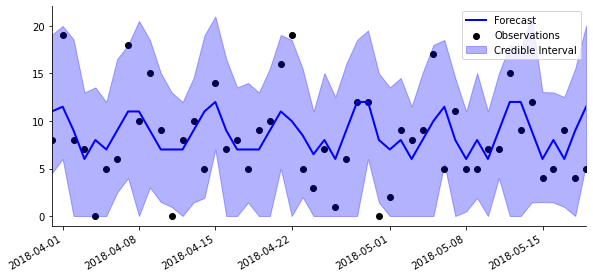

In [10]:
# Plotting 1-step ahead forecasts

horizon = 1 
plot_length = 50
fig, ax = plt.subplots(figsize=(8,4))
start_date = forecast_end_date + pd.DateOffset(horizon - plot_length)
end_date = forecast_end_date + pd.DateOffset(horizon - 1)
ax = plot_data_forecast(fig, ax, data.loc[start_date:end_date].Y,
                        forecast[-plot_length:,horizon - 1],
                        forecast_samples[:,-plot_length:,horizon - 1],
                        data.loc[start_date:end_date].index,
                        linewidth = 2)

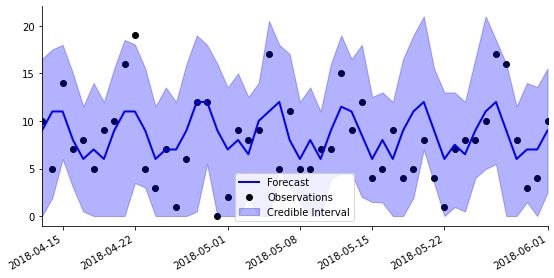

In [11]:
# Plotting 14-step ahead forecasts

horizon = 14
plot_length = 50
fig, ax = plt.subplots(figsize=(8,4))
start_date = forecast_end_date + pd.DateOffset(horizon - plot_length)
end_date = forecast_end_date + pd.DateOffset(horizon - 1)
ax = plot_data_forecast(fig, ax, data.loc[start_date:end_date].Y,
                        forecast[-plot_length:,horizon - 1],
                        forecast_samples[:,-plot_length:,horizon - 1],
                        data.loc[start_date:end_date].index,
                        linewidth = 2)

To evaluate the point forecasts, we can look at the mean absolute deviation (MAD) between the forecast median and the observations across forecast horizons. Interestingly, there is only a small increase in the MAD for longer forecast horizons.

In [12]:
# Mean absolute deviation at increasing forecast horizons
horizons = list(range(1, k+1))
list(map(lambda k: MAD(data.loc[forecast_start_date + pd.DateOffset(k-1):forecast_end_date + pd.DateOffset(k-1)].Y,
                      forecast[:,k-1]),
         horizons))

[2.8756830601092895,
 2.9139344262295084,
 2.8538251366120218,
 2.8743169398907105,
 2.8442622950819674,
 2.887978142076503,
 2.8647540983606556,
 2.819672131147541,
 2.898907103825137,
 2.8934426229508197,
 2.883879781420765,
 2.819672131147541,
 2.8852459016393444,
 2.8579234972677594]